In [1]:
from itertools import combinations_with_replacement
from collections import defaultdict

import numpy as np
from numpy.linalg import inv

import cv2


In [3]:
B, G, R = 0, 1, 2  # index for convenience

def boxfilter(I, r):
    
    M, N = I.shape
    dest = np.zeros((M, N))
    #print(I)
    
    
    sumY = np.cumsum(I, axis=0)
    
    dest[:r + 1] = sumY[r:2*r + 1] # top r+1 lines
    dest[r + 1:M - r] = sumY[2*r + 1:] - sumY[:M - 2*r - 1]
    
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2*r - 1:M - r - 1] # bottom r lines

    
    sumX = np.cumsum(dest, axis=1)
    
    dest[:, :r + 1] = sumX[:, r:2*r + 1] # left r+1 columns
    dest[:, r + 1:N - r] = sumX[:, 2*r + 1:] - sumX[:, :N - 2*r - 1]
    dest[:, -r:] = np.tile(sumX[:, -1][:, None], (1, r)) - sumX[:, N - 2*r - 1:N - r - 1] # right r columns

    #print(dest)

    return dest

In [5]:
def guided_filter(I, p, r=15, eps=1e-3):
    
    
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r) # this is needed for regularization
    
    # each channel of I filtered with the mean filter. this is myu.
    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]
    
    # p filtered with the mean filter
    mean_p = boxfilter(p, r) / base

    # filter I with p then filter it with the mean filter
    means_IP = [boxfilter(I[:, :, i]*p, r) / base for i in range(3)]

    # covariance of (I, p) in each local patch
    covIP = [means_IP[i] - means[i]*mean_p for i in range(3)]

    # variance of I in each local patch: the matrix Sigma in ECCV10 eq.14
    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(I[:, :, i]*I[:, :, j], r) / base - means[i]*means[j]

    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):
        #         rr, rg, rb
        # Sigma = rg, gg, gb
        #         rb, gb, bb
        Sigma = np.array([[var[B][B][y, x], var[B][G][y, x], var[B][R][y, x]],
                          [var[B][G][y, x], var[G][G][y, x], var[G][R][y, x]],
                          [var[B][R][y, x], var[G][R][y, x], var[R][R][y, x]]])
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(cov, inv(Sigma + eps*np.eye(3)))  # eq 14

    # ECCV10 eq.15
    b = mean_p - a[:, :, R]*means[R] - a[:, :, G]*means[G] - a[:, :, B]*means[B]

    # ECCV10 eq.16
    q = (boxfilter(a[:, :, R], r)*I[:, :, R] + boxfilter(a[:, :, G], r)*I[:, :, G] + boxfilter(a[:, :, B], r)*I[:, :, B] + boxfilter(b, r)) / base

    return q

In [6]:
def get_illumination_channel(I, w):
    M, N, _ = I.shape
    padded = np.pad(I, ((int(w/2), int(w/2)), (int(w/2), int(w/2)), (0, 0)), 'edge')
    darkch = np.zeros((M, N))
    brightch = np.zeros((M, N))

    for i, j in np.ndindex(darkch.shape):
        darkch[i, j] = np.min(padded[i:i + w, j:j + w, :])
        brightch[i, j] = np.max(padded[i:i + w, j:j + w, :])

    return darkch, brightch

In [7]:
def get_atmosphere(I, brightch, p=0.1):
    M, N = brightch.shape
    flatI = I.reshape(M*N, 3)
    flatbright = brightch.ravel()

    searchidx = (-flatbright).argsort()[:int(M*N*p)]
    A = np.mean(flatI.take(searchidx, axis=0), dtype=np.float64, axis=0)
    return A

In [8]:
def get_initial_transmission(A, brightch):
    A_c = np.max(A)
    init_t = (brightch-A_c)/(1.-A_c)
    return (init_t - np.min(init_t))/(np.max(init_t) - np.min(init_t))

In [10]:
def get_corrected_transmission(I, A, darkch, brightch, init_t, alpha, omega, w):
    im3 = np.empty(I.shape, I.dtype);
    for ind in range(0, 3):
        im3[:, :, ind] = I[:, :, ind] / A[ind]
    dark_c, _ = get_illumination_channel(im3, w)
    dark_t = 1 - omega*dark_c
    corrected_t = init_t
    diffch = brightch - darkch
    
    for i in range(diffch.shape[0]):
        for j in range(diffch.shape[1]):
            if(diffch[i, j] < alpha):
                corrected_t[i, j] = dark_t[i, j] * init_t[i, j]

    return np.abs(corrected_t)

In [11]:
def get_final_image(I, A, refined_t, tmin):
    refined_t_broadcasted = np.broadcast_to(refined_t[:, :, None], (refined_t.shape[0], refined_t.shape[1], 3))
    J = (I-A) / (np.where(refined_t_broadcasted < tmin, tmin, refined_t_broadcasted)) + A

    return (J - np.min(J))/(np.max(J) - np.min(J))

In [12]:

def dehaze(I, tmin, w, alpha, omega, p, eps, reduce=False):
    m, n, _ = I.shape
    Idark, Ibright = get_illumination_channel(I, w)
    A = get_atmosphere(I, Ibright, p)

    init_t = get_initial_transmission(A, Ibright) 
    if reduce:
        init_t = reduce_init_t(init_t)
    corrected_t = get_corrected_transmission(I, A, Idark, Ibright, init_t, alpha, omega, w)

    normI = (I - I.min()) / (I.max() - I.min())
    refined_t = guided_filter(normI, corrected_t, w, eps)
    J_refined = get_final_image(I, A, refined_t, tmin)
    
    enhanced = (J_refined*255).astype(np.uint8)
    f_enhanced = cv2.detailEnhance(enhanced, sigma_s=10, sigma_r=0.15)
    f_enhanced = cv2.edgePreservingFilter(f_enhanced, flags=1, sigma_s=64, sigma_r=0.2)
    return f_enhanced

In [13]:
def reduce_init_t(init_t):
    init_t = (init_t*255).astype(np.uint8)
    xp = [0, 32, 255]
    fp = [0, 32, 48]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    init_t = cv2.LUT(init_t, table)
    init_t = init_t.astype(np.float64)/255
    return init_t

In [14]:
#--------------#
# Applying Illumination on an image
#--------------#

In [23]:
im = cv2.imread('./images/test1.jpg')
orig = im.copy()
tmin = 0.1   # minimum value for t to make J image
w = 15       # window size, which determine the corseness of prior images
alpha = 0.4  # threshold for transmission correction
omega = 0.75 # this is for dark channel prior
p = 0.1      # percentage to consider for atmosphere
eps = 1e-3   # for J image

I = np.asarray(im, dtype=np.float64) # Convert the input to an array.
I = I[:, :, :3] / 255

f_enhanced = dehaze(I, tmin, w, alpha, omega, p, eps)
f_enhanced2 = dehaze(I, tmin, w, alpha, omega, p, eps, True)

cv2.imwrite("./output/out1.jpg",f_enhanced2)

True

### Displaying the results


In [26]:
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

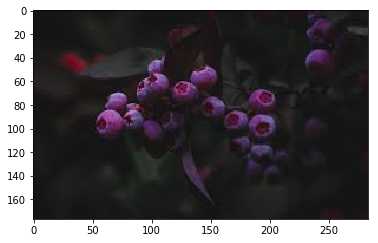

In [27]:
# Displaying the input image
pil_im = Image.open('./images/test3.jpg')
im_array = np.asarray(pil_im)
plt.imshow(im_array)
plt.show()

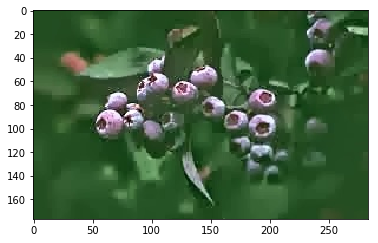

In [29]:
pil_im = Image.open('./output/out3.jpg')
im_array = np.asarray(pil_im)
plt.imshow(im_array)
plt.show()